In [41]:
import random
from math import exp
import matplotlib.pyplot as plt
# process data label as 0, 1, 2 for training
def loadDataset(dataset): 
    newdata = []
    for x in range(len(dataset)-1):
        for i in range(0,len(dataset[x]),4):
            if dataset[x][i] == "I": # encounter labels, change it
                if dataset[x][-3:-1] == "sa": # Iris-setosa
                    newdata.append(0)
                elif dataset[x][-2:-1] == "r": # Iris-versicolor
                    newdata.append(1)
                elif dataset[x][-3:-1] == "ca": # Iris-virginica
                    newdata.append(2) 
                break
            else:
                attribute = float(dataset[x][i:i+3])
                newdata.append(attribute)
        trainingSet.append(newdata)       
        newdata = [] # clear the package
    return trainingSet

# find the range of data to do normalize
def dataset_minmax(dataset): # zip a(1,2,3) , b(4,5,6) to [(1,4), (2,5), (3,6)] 
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)] # unzip the file
    return stats

# rescale data to range 0~1
def normalize_data(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# transfer neuron activation 
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

#forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs # keep updating the neurons
    return inputs

# backpropagate error and sotre in neurons
def backward_propagate_error(network, expected): 
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)): # hidden
                error = 0.0
                for neuron in network[i+1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error) 
        else:
            for j in range(len(layer)): # output
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# update network weights with error
def update_weights(network, row, learning_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += learning_rate * neuron['delta'] * inputs[j]
                neuron['weights'][-1] += learning_rate * neuron['delta']
            
def train_network(network, train, learning_rate, n_epoch, n_outputs):
    print("--------------- lrate=%.3f" % learning_rate ,"-----------------")
    prev_MSE = 0
    MSE = 0
    abs_fraction_of_change = 0
    
    for epoch in range(n_epoch):
        MSE = 0
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1 # one hot encoding !!!
            backward_propagate_error(network, expected)
            update_weights(network, row, learning_rate)
            update_outputs = forward_propagate(network, row) # update forward results
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            MSE += sum([(expected[i] - update_outputs[i])**2 for i in range(len(expected))])
            #print(MSE)
        MSE /= len(expected)
        if epoch > 0:
            abs_fraction_of_change = abs((MSE - prev_MSE) / prev_MSE )
            if abs_fraction_of_change <= 10e-5:
                print("Epoch need:%d"%(epoch+1))
                break
        print('>epoch=%d, MSE=%.3f, abs fraction of change=%.6f' % (epoch, MSE, abs_fraction_of_change))
        #print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, learning_rate, sum_error))
        prev_MSE = MSE
        #print("prev",prev_MSE)
        
        predicted = [predict(network, row) for row in train]
        actual = [row[-1] for row in train]
        accuracy = accuracy_metric(actual, predicted)
    return (epoch+1)
   

def init_network(n_inputs, n_hidden, n_outputs): 
# create n_hidden neurons and each neuron in the hidden layer has n_inputs + 1 weights
    network = list() 
    hidden_layer1 = [{'weights': [(random.random()-0.5)/5.0 for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer1) 
    hidden_layer2 = [{'weights': [(random.random()-0.5)/5.0 for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer2)
    output_layer = [{'weights': [(random.random()-0.5)/5.0  for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer) 
    return network

# make a prediction with a network
# It returns the index in the network output that has the largest probability. 
# Assuming that class values have been converted to integers starting at 0. [0,1,2]
def predict(network, row):
    outputs = forward_propagate(network, row)
    #print(outputs)
    return outputs.index(max(outputs))

# backpropagation with stochastic gradient descent
def back_propagate(train, learning_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = init_network(n_inputs, n_hidden, n_outputs)
    epoch = train_network(network, train, learning_rate, n_epoch, n_outputs)
    return epoch
    

In [42]:
trainingSet=[]
testSet=[]
results = []
f = open('iris.data.txt', "r")
lines = f.readlines()
dataset = list(lines)
trainingSet = loadDataset(dataset)

In [43]:
# normalize inputs

minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.1
n_epoch = 700
n_hidden = 4
scores = list()
epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)



--------------- lrate=0.100 -----------------
>epoch=0, MSE=23.856, abs fraction of change=0.000000
>epoch=1, MSE=27.451, abs fraction of change=0.150675
>epoch=2, MSE=27.791, abs fraction of change=0.012373
>epoch=3, MSE=27.825, abs fraction of change=0.001233
>epoch=4, MSE=27.840, abs fraction of change=0.000541
>epoch=5, MSE=27.854, abs fraction of change=0.000493
>epoch=6, MSE=27.867, abs fraction of change=0.000485
>epoch=7, MSE=27.881, abs fraction of change=0.000480
>epoch=8, MSE=27.894, abs fraction of change=0.000475
>epoch=9, MSE=27.907, abs fraction of change=0.000470
>epoch=10, MSE=27.920, abs fraction of change=0.000465
>epoch=11, MSE=27.933, abs fraction of change=0.000460
>epoch=12, MSE=27.945, abs fraction of change=0.000455
>epoch=13, MSE=27.958, abs fraction of change=0.000450
>epoch=14, MSE=27.970, abs fraction of change=0.000445
>epoch=15, MSE=27.983, abs fraction of change=0.000439
>epoch=16, MSE=27.995, abs fraction of change=0.000434
>epoch=17, MSE=28.007, abs fr

In [44]:
# normalize inputs
dataset = list(lines)
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.2
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.200 -----------------
>epoch=0, MSE=39.847, abs fraction of change=0.000000
>epoch=1, MSE=44.992, abs fraction of change=0.129116
>epoch=2, MSE=45.171, abs fraction of change=0.003986
>epoch=3, MSE=45.342, abs fraction of change=0.003776
>epoch=4, MSE=45.506, abs fraction of change=0.003618
>epoch=5, MSE=45.663, abs fraction of change=0.003453
>epoch=6, MSE=45.813, abs fraction of change=0.003284
>epoch=7, MSE=45.955, abs fraction of change=0.003114
>epoch=8, MSE=46.091, abs fraction of change=0.002944
>epoch=9, MSE=46.219, abs fraction of change=0.002778
>epoch=10, MSE=46.340, abs fraction of change=0.002616
>epoch=11, MSE=46.454, abs fraction of change=0.002461
>epoch=12, MSE=46.561, abs fraction of change=0.002312
>epoch=13, MSE=46.662, abs fraction of change=0.002171
>epoch=14, MSE=46.757, abs fraction of change=0.002037
>epoch=15, MSE=46.847, abs fraction of change=0.001910
>epoch=16, MSE=46.931, abs fraction of change=0.001791
>epoch=17, MSE=47.009, abs fr

In [45]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.3
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.300 -----------------
>epoch=0, MSE=53.034, abs fraction of change=0.000000
>epoch=1, MSE=58.364, abs fraction of change=0.100501
>epoch=2, MSE=58.930, abs fraction of change=0.009709
>epoch=3, MSE=59.439, abs fraction of change=0.008630
>epoch=4, MSE=59.888, abs fraction of change=0.007556
>epoch=5, MSE=60.279, abs fraction of change=0.006536
>epoch=6, MSE=60.617, abs fraction of change=0.005603
>epoch=7, MSE=60.907, abs fraction of change=0.004785
>epoch=8, MSE=61.156, abs fraction of change=0.004088
>epoch=9, MSE=61.371, abs fraction of change=0.003505
>epoch=10, MSE=61.556, abs fraction of change=0.003018
>epoch=11, MSE=61.716, abs fraction of change=0.002608
>epoch=12, MSE=61.856, abs fraction of change=0.002262
>epoch=13, MSE=61.978, abs fraction of change=0.001969
>epoch=14, MSE=62.085, abs fraction of change=0.001723
>epoch=15, MSE=62.179, abs fraction of change=0.001516
>epoch=16, MSE=62.262, abs fraction of change=0.001340
>epoch=17, MSE=62.336, abs fr

In [46]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.4
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.400 -----------------
>epoch=0, MSE=64.044, abs fraction of change=0.000000
>epoch=1, MSE=69.926, abs fraction of change=0.091841
>epoch=2, MSE=71.057, abs fraction of change=0.016170
>epoch=3, MSE=71.939, abs fraction of change=0.012420
>epoch=4, MSE=72.607, abs fraction of change=0.009286
>epoch=5, MSE=73.110, abs fraction of change=0.006922
>epoch=6, MSE=73.492, abs fraction of change=0.005223
>epoch=7, MSE=73.786, abs fraction of change=0.004006
>epoch=8, MSE=74.017, abs fraction of change=0.003126
>epoch=9, MSE=74.200, abs fraction of change=0.002480
>epoch=10, MSE=74.349, abs fraction of change=0.001999
>epoch=11, MSE=74.470, abs fraction of change=0.001636
>epoch=12, MSE=74.571, abs fraction of change=0.001357
>epoch=13, MSE=74.656, abs fraction of change=0.001140
>epoch=14, MSE=74.729, abs fraction of change=0.000969
>epoch=15, MSE=74.791, abs fraction of change=0.000831
>epoch=16, MSE=74.845, abs fraction of change=0.000719
>epoch=17, MSE=74.892, abs fr

In [47]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.5
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.500 -----------------
>epoch=0, MSE=73.583, abs fraction of change=0.000000
>epoch=1, MSE=80.231, abs fraction of change=0.090347
>epoch=2, MSE=81.952, abs fraction of change=0.021450
>epoch=3, MSE=83.073, abs fraction of change=0.013672
>epoch=4, MSE=83.794, abs fraction of change=0.008682
>epoch=5, MSE=84.270, abs fraction of change=0.005683
>epoch=6, MSE=84.600, abs fraction of change=0.003919
>epoch=7, MSE=84.840, abs fraction of change=0.002830
>epoch=8, MSE=85.019, abs fraction of change=0.002112
>epoch=9, MSE=85.157, abs fraction of change=0.001618
>epoch=10, MSE=85.265, abs fraction of change=0.001270
>epoch=11, MSE=85.351, abs fraction of change=0.001017
>epoch=12, MSE=85.422, abs fraction of change=0.000830
>epoch=13, MSE=85.481, abs fraction of change=0.000688
>epoch=14, MSE=85.530, abs fraction of change=0.000578
>epoch=15, MSE=85.573, abs fraction of change=0.000492
>epoch=16, MSE=85.609, abs fraction of change=0.000423
>epoch=17, MSE=85.640, abs fr

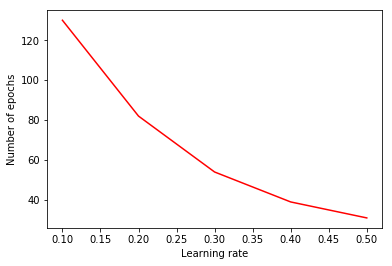

In [48]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], results, 'r')
plt.xlabel("Learning rate")
plt.ylabel("Number of epochs")
plt.show()